In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
import os

2.5.0


In [2]:
# !pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [3]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  []


In [4]:
data_train = pd.read_csv(r'C:\Users\user\Desktop\all_cups\missing_planes\data\train.csv', dtype=str)
data_test = pd.read_csv(r'C:\Users\user\Desktop\all_cups\missing_planes\data\test.csv', dtype=str)
data_train.head(3)

,sign,filename
0,0,200d8766-4240-44d1-a2da-65dc4ee7973a
1,0,87174854-b7b6-4cb2-8183-4ca2bbd26b9d
2,0,c089638e-b683-436a-a3a3-3e5be972c4f6


In [5]:
def append_png(fn):
    return fn+".png"
data_train["png"]=data_train["filename"].apply(append_png)
data_test["png"]=data_test["filename"].apply(append_png)

In [6]:
samples = np.random.rand(len(data_train)) < 0.8
df_train = data_train[samples]
df_test = data_train[~samples]

In [7]:
base_dir = r'C:\Users\user\Desktop\all_cups\missing_planes\data'
train_dir = r'C:\Users\user\Desktop\all_cups\missing_planes\data\avia-train'
test_dir = r'C:\Users\user\Desktop\all_cups\missing_planes\data\avia-test'
cpt_path = r'C:\Users\user\Desktop\all_cups\missing_planes\data\models'

In [8]:
BATCH_SIZE=128
IMAGE_SIZE = 20
train_gen = ImageDataGenerator(
    rotation_range=45,
    rescale=1./255, 
    horizontal_flip=True
)
test_gen = ImageDataGenerator(rescale = 1./255)

In [12]:
train_data = train_gen.flow_from_dataframe(dataframe=df_train, 
                                           directory=train_dir, x_col='png', 
                                           y_col='sign', seed=42, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=False,  
                                           class_mode='binary',
                                           validate_filenames=False,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE))

val_data = train_gen.flow_from_dataframe(dataframe=df_test, 
                                           directory=train_dir, x_col='png', 
                                           y_col='sign', 
                                           batch_size=BATCH_SIZE,
                                           shuffle=False,  
                                           class_mode='binary',
                                           validate_filenames=False,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE))

test_data = test_gen.flow_from_dataframe(dataframe=data_test, 
                                         directory=test_dir, x_col='png', 
                                         y_col=None,
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         class_mode=None,
                                         validate_filenames=False,
                                         target_size=(IMAGE_SIZE, IMAGE_SIZE))

full_data = train_gen.flow_from_dataframe(dataframe=data_train, 
                                           directory=train_dir, x_col='png', 
                                           y_col='sign', seed=42, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,  
                                           class_mode='binary',
                                           validate_filenames=False,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 24867 non-validated image filenames belonging to 2 classes.
Found 6213 non-validated image filenames belonging to 2 classes.
Found 1000 non-validated image filenames.
Found 31080 non-validated image filenames belonging to 2 classes.


In [13]:
def make_model(dropout=0.0):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                  activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss=tf.keras.losses.binary_crossentropy,
                metrics=[tf.keras.metrics.AUC()])
    return model

model = make_model(dropout=0.5)

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 20, 20, 32)        896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 10, 64)       

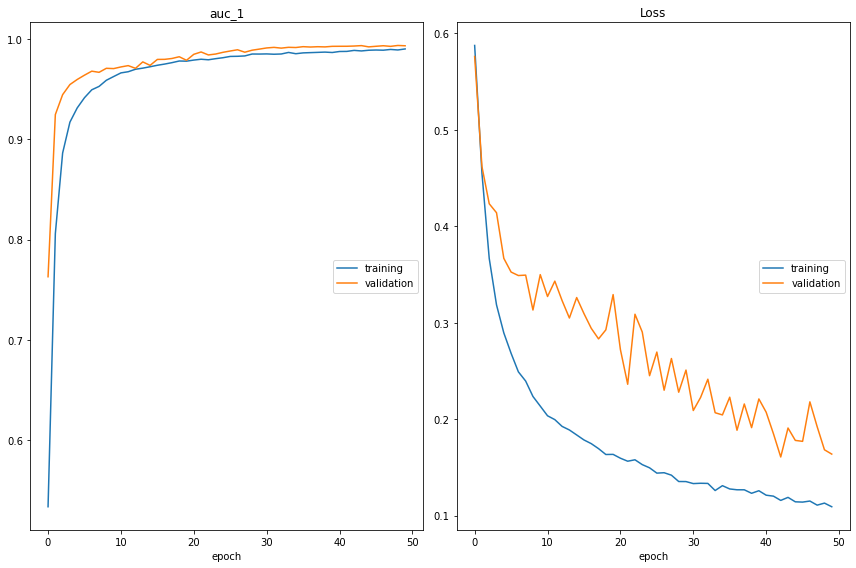

auc_1
	training         	 (min:    0.533, max:    0.990, cur:    0.990)
	validation       	 (min:    0.763, max:    0.994, cur:    0.993)
Loss
	training         	 (min:    0.109, max:    0.587, cur:    0.109)
	validation       	 (min:    0.161, max:    0.576, cur:    0.164)


In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=1, save_best_only=True)

EPOCHS = 50
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[checkpoint, PlotLossesCallback()])

In [16]:
val_data_pred = model.predict(val_data)
fpr, tpr, thresholds = roc_curve(df_test['sign'].astype(int), val_data_pred)

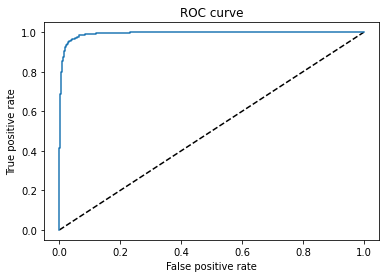

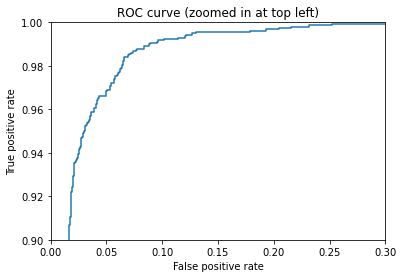

In [17]:
def plot_roc_curve(fpr,tpr): 
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.3)
    plt.ylim(0.9, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.show()

plot_roc_curve(fpr,tpr) 

In [18]:
auc_score=roc_auc_score(df_test['sign'].astype(int), val_data_pred)
auc_score

0.9931791891688398

In [19]:
def submit(data_test, predict, auc=0.9):
    test = pd.DataFrame(predict, columns=['Predict'])
    result = pd.concat([data_test, test], axis=1)
    result['sign']  = result['Predict'].apply(lambda x: 1 if x > auc else 0)
    result.drop(['png', 'Predict'], axis=1, inplace=True)
    result.to_csv('Subbmision.csv', columns=['sign', 'filename'], index=False)

In [20]:
def full_model_learn(EPOCHS):
    model.fit(full_data, epochs=EPOCHS, callbacks=[checkpoint, PlotLossesCallback()])
    model_best = make_model(dropout=0.5)
    model_best.load_weights(cpt_path)
    predict = model.predict(test_data)
    return predict

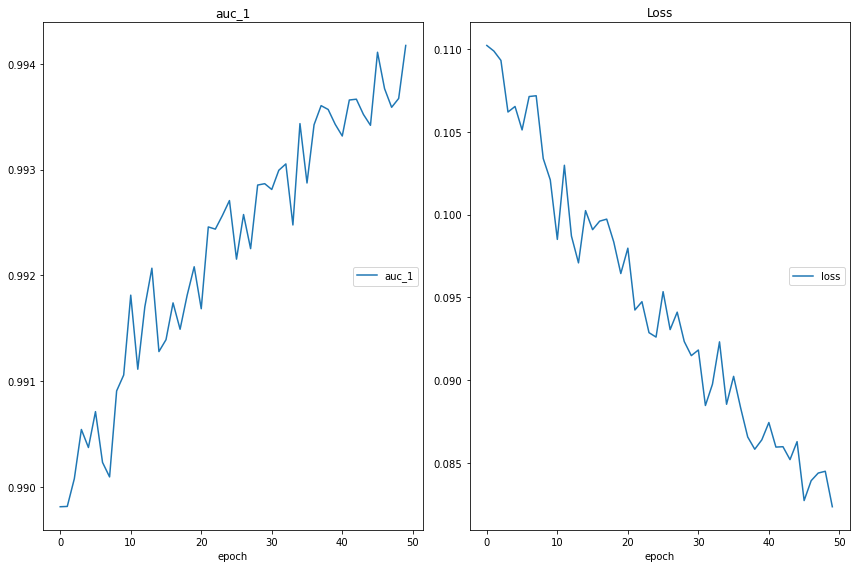

auc_1
	auc_1            	 (min:    0.990, max:    0.994, cur:    0.994)
Loss
	loss             	 (min:    0.082, max:    0.110, cur:    0.082)


In [22]:
full_pred = full_model_learn(50)

In [ ]:
# model_best = make_model(dropout=0.5)
# model_best.load_weights(cpt_path)
# full_pred = model.predict(test_data)

In [28]:
submit(data_test, full_pred, auc=0.25)

In [23]:
test = pd.DataFrame(full_pred, columns=['Predict'])
test.head()

,Predict
0,0.030871
1,0.008766
2,0.001067
3,0.936096
4,0.000627


In [24]:
df_test['sign'].astype(int).sum()

1575

In [25]:
for i in np.arange(0, 1, 0.005):
    test['sign' + '_' + str(i)]  = test['Predict'].apply(lambda x: 1 if x > i else 0)
test.head()
for col in test.columns:
    print(col, test[col].astype(int).sum())

Predict 0
sign_0.0 1000
sign_0.005 456
sign_0.01 388
sign_0.015 358
sign_0.02 332
sign_0.025 318
sign_0.03 301
sign_0.035 292
sign_0.04 282
sign_0.045 276
sign_0.05 274
sign_0.055 268
sign_0.06 262
sign_0.065 258
sign_0.07 257
sign_0.075 256
sign_0.08 254
sign_0.085 249
sign_0.09 245
sign_0.095 242
sign_0.1 238
sign_0.105 235
sign_0.11 231
sign_0.115 228
sign_0.12 226
sign_0.125 225
sign_0.13 223
sign_0.135 220
sign_0.14 219
sign_0.145 215
sign_0.15 214
sign_0.155 213
sign_0.16 213
sign_0.165 210
sign_0.17 210
sign_0.17500000000000002 210
sign_0.18 206
sign_0.185 206
sign_0.19 206
sign_0.195 205
sign_0.2 205
sign_0.20500000000000002 203
sign_0.21 203
sign_0.215 201
sign_0.22 201
sign_0.225 196
sign_0.23 196
sign_0.23500000000000001 194
sign_0.24 193
sign_0.245 192
sign_0.25 190
sign_0.255 189
sign_0.26 189
sign_0.265 188
sign_0.27 187
sign_0.275 186
sign_0.28 185
sign_0.28500000000000003 185
sign_0.29 185
sign_0.295 184
sign_0.3 183
sign_0.305 183
sign_0.31 183
sign_0.315 183
sign_0.32

In [27]:
data_test['sign']

KeyError: 'sign'